# AI Weather Prediction Project Notebook

#### Order
1. Decision Tree Regressor
2. XGBoost Classification: Precipitation Percentage
3. XGBoost Classification: Precipitation Category
4. TensorFlow Neuro Network

#### Load Libraries to be used by all models. 

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost

from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from joblib import dump, load

plt.rcParams['figure.figsize']=(6,4)

In [139]:
!pip install openpyxl


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [140]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Decision Tree Regressor

In [141]:
weather_data = pd.read_excel('weather_data_excel.xlsx')
print(weather_data.columns)


Index(['Location', 'Date_Time', 'Temperature_C', 'Humidity_pct',
       'Precipitation_mm', 'Wind_Speed_kmh', 'Temperature_F', 'Date',
       'Military_Time', 'Rain_Category', 'Rain_Cat_Num', 'Precipitation_in'],
      dtype='object')


In [142]:
y = weather_data['Precipitation_mm']
X = weather_data.drop(columns=['Precipitation_mm', 'Rain_Category', 'Location', 'Date', 'Military_Time',  'Precipitation_in', 'Temperature_C', 'Rain_Cat_Num', 'Date_Time'])

In [143]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F'], dtype='object')

In [144]:
y.describe()

count    1000000.000000
mean           5.109639
std            2.947997
min            0.000009
25%            2.580694
50%            5.109917
75%            7.613750
max           14.971583
Name: Precipitation_mm, dtype: float64

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [146]:
print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (800000, 3)
y_train.shape =  (800000,)
X_test.shape =  (200000, 3)
y_test.shape =  (200000,)


In [147]:
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [148]:
y_train_pred = dt.predict(X_train)
print(r2_score(y_train, y_train_pred))
y_test_pred = dt.predict(X_test)
print(r2_score(y_test, y_test_pred))

0.004189520881980435
0.0013837069571025484


In [149]:
y_train_pred

array([5.09270754, 5.11908651, 5.11908651, ..., 5.11908651, 5.09270754,
       5.11908651])

In [150]:
y_test_pred

array([5.09270754, 5.11908651, 5.11908651, ..., 5.09270754, 5.11908651,
       5.11908651])

In [151]:
training_r2 = []
testing_r2 = []

In [152]:
for depth in range(1, 5):
    dtr = DecisionTreeRegressor( max_depth = depth )
    dtr.fit(X_train, y_train)
    
    y_train_pred = dtr.predict(X_train)
    
    # Training R2 Score
    training_r2.append(r2_score(y_train, y_train_pred))

    y_test_pred = dtr.predict(X_test)

    # Testing R2 Score
    testing_r2.append(r2_score(y_test, y_test_pred))    
    

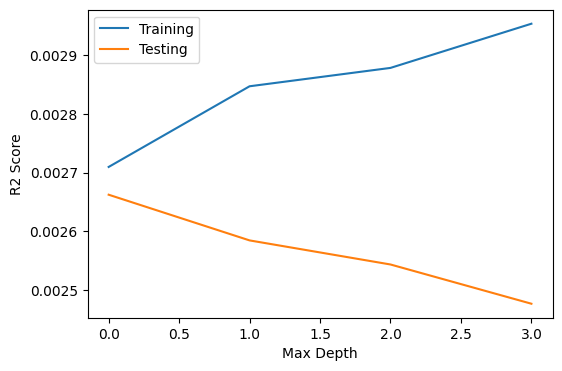

In [153]:
plt.plot(training_r2, label="Training")
plt.plot(testing_r2, label = "Testing")
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')
plt.legend(loc = 'upper left')
plt.show()

## XGBoost Regressor 

In [154]:
df = pd.read_excel('weather_data_excel.xlsx')

In [155]:
df['Date'] = pd.to_datetime(df['Date'])

In [156]:
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year

In [157]:
location_encoder = LabelEncoder()
df['Location_encoded'] = location_encoder.fit_transform(df['Location'])

In [158]:
# Establish X and y
y = df['Precipitation_mm']
X = df.drop(columns=['Precipitation_mm','Military_Time','Rain_Category', 'Location', 'Date', 'Precipitation_in', 'Temperature_C', 'Rain_Cat_Num', 'Date_Time'])

In [159]:
# Check if the correct columns for X have been added
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Month', 'Day',
       'Year', 'Location_encoded'],
      dtype='object')

In [160]:
# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4700)

In [161]:
# Create XGBoost Regression Model

xgb_r = xgboost.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators = 10 )

In [162]:
# Fit the model
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [163]:
# Determine Training R2 Score
prediction = xgb_r.predict(X_train)
training_r2 = r2_score(y_train, prediction )
training_r2

0.031871178280234

In [164]:
# Determine Testing R2 Score
prediction = xgb_r.predict(X_test)
testing_r2 = r2_score(y_test, prediction )
testing_r2

0.028456828603085516

### Test XGBoost Regressor at depths 1 through 10

In [165]:
training_r2 = []
testing_r2 = []

In [166]:
for depth in range(1, 11):
    xgb_r = xgboost.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators = depth )
    xgb_r.fit(X_train, y_train)
    
    y_train_pred = xgb_r.predict(X_train)
    training_r2.append(r2_score(y_train, y_train_pred))
    
    y_test_pred = xgb_r.predict(X_test)
    testing_r2.append(r2_score(y_test, y_test_pred))
    

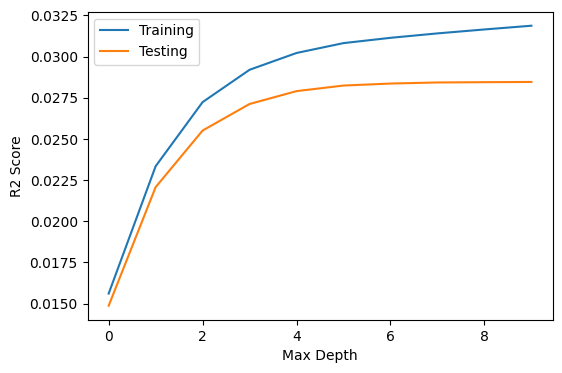

In [167]:
plt.plot(training_r2, label="Training")
plt.plot(testing_r2, label = "Testing")
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')
plt.legend(loc = 'upper left')
plt.show()

## XGBoost Classifier: Percentage Rainfall


In [168]:
data_frame = pd.read_excel('weather_data_excel.xlsx')

In [169]:
data_frame['Date'] = pd.to_datetime(data_frame['Date'])

In [170]:
data_frame['Month'] = data_frame['Date'].dt.month
data_frame['Day'] = data_frame['Date'].dt.day
data_frame['Year'] = data_frame['Date'].dt.year

In [171]:
location_encoder = LabelEncoder()

In [172]:
data_frame['Location_encoded'] = location_encoder.fit_transform(data_frame['Location'])

In [173]:
# This is the threshold, in mm, for if rainfall is classified as rain or not
threshold = 5.0
data_frame['Rainfall'] = (data_frame['Precipitation_mm'] >= threshold).astype(int)

In [174]:
y=data_frame['Rainfall']

In [175]:
X = data_frame.drop(columns=['Precipitation_in', 'Precipitation_mm', 'Date', 'Military_Time', 'Rain_Category', 'Rain_Cat_Num', 'Location', 'Rainfall', 'Date_Time', 'Temperature_C'])

In [176]:
X.columns

Index(['Humidity_pct', 'Wind_Speed_kmh', 'Temperature_F', 'Month', 'Day',
       'Year', 'Location_encoded'],
      dtype='object')

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4700)

In [178]:
xgb_c = xgboost.XGBClassifier( n_estimators = 100, max_depth = 10 )

In [179]:
xgb_c.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [180]:
y_train_pred = xgb_c.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
training_accuracy

0.678985

In [181]:
y_test_pred = xgb_c.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_test_pred)
testing_accuracy


0.511295

In [182]:
# Saving the model and encoder
#dump(xgb_c, 'rain_probability_predictor.pkl')
#dump(location_encoder, 'location_encoder.pkl')

### Visualise Data

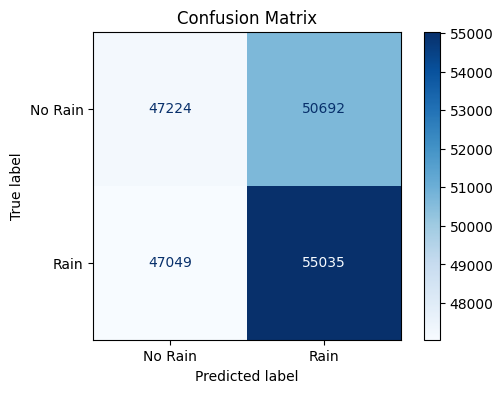

In [183]:
y_pred = xgb_c.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## XGBoost Classifier

In [184]:
# Write XGB Classifier Code Here
# edf = pd.read_excel('weather_data_excel.xlsx')
edf = pd.read_excel('weather_data_excel.xlsx')
edf = edf.iloc[:1000000]
edf

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Date,Military_Time,Rain_Category,Rain_Cat_Num,Precipitation_in
0,San Jose,2024-04-16 03:44:08,17.199707,71.429300,0.000009,4.665638,62.959473,2024-04-16,03:44,Light Rain,0,3.505573e-07
1,Houston,2024-03-21 15:32:17,2.238515,51.415780,0.000010,3.578842,36.029327,2024-03-21,15:32,Light Rain,0,4.092205e-07
2,Houston,2024-02-27 01:05:28,29.209095,50.340174,0.000029,9.968438,84.576371,2024-02-27,01:05,Light Rain,0,1.157432e-06
3,Phoenix,2024-04-23 00:39:36,15.041607,78.159361,0.000032,21.713389,59.074893,2024-04-23,00:39,Light Rain,0,1.261625e-06
4,San Diego,2024-05-02 20:45:35,12.799834,62.244326,0.000089,27.277552,55.039702,2024-05-02,20:45,Light Rain,0,3.493707e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,Phoenix,2024-02-22 08:35:12,-0.872399,37.180646,14.896195,18.147337,30.429682,2024-02-22,08:35,Heavy Rain,2,5.864644e-01
999996,Phoenix,2024-01-10 19:03:39,14.200155,78.319692,14.912323,19.157155,57.560279,2024-01-10,19:03,Heavy Rain,2,5.870993e-01
999997,Phoenix,2024-01-08 21:01:01,19.848658,75.733769,14.917006,15.453639,67.727585,2024-01-08,21:01,Heavy Rain,2,5.872837e-01
999998,Phoenix,2024-01-16 08:12:36,-3.586550,81.166402,14.926332,13.758749,25.544210,2024-01-16,08:12,Heavy Rain,2,5.876509e-01


In [185]:
edf['Hour'] = edf['Military_Time'].apply(lambda x: int(x.split(":")[0]))
edf['Minute'] = edf['Military_Time'].apply(lambda x: int(x.split(":")[1]))
edf

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Temperature_F,Date,Military_Time,Rain_Category,Rain_Cat_Num,Precipitation_in,Hour,Minute
0,San Jose,2024-04-16 03:44:08,17.199707,71.429300,0.000009,4.665638,62.959473,2024-04-16,03:44,Light Rain,0,3.505573e-07,3,44
1,Houston,2024-03-21 15:32:17,2.238515,51.415780,0.000010,3.578842,36.029327,2024-03-21,15:32,Light Rain,0,4.092205e-07,15,32
2,Houston,2024-02-27 01:05:28,29.209095,50.340174,0.000029,9.968438,84.576371,2024-02-27,01:05,Light Rain,0,1.157432e-06,1,5
3,Phoenix,2024-04-23 00:39:36,15.041607,78.159361,0.000032,21.713389,59.074893,2024-04-23,00:39,Light Rain,0,1.261625e-06,0,39
4,San Diego,2024-05-02 20:45:35,12.799834,62.244326,0.000089,27.277552,55.039702,2024-05-02,20:45,Light Rain,0,3.493707e-06,20,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,Phoenix,2024-02-22 08:35:12,-0.872399,37.180646,14.896195,18.147337,30.429682,2024-02-22,08:35,Heavy Rain,2,5.864644e-01,8,35
999996,Phoenix,2024-01-10 19:03:39,14.200155,78.319692,14.912323,19.157155,57.560279,2024-01-10,19:03,Heavy Rain,2,5.870993e-01,19,3
999997,Phoenix,2024-01-08 21:01:01,19.848658,75.733769,14.917006,15.453639,67.727585,2024-01-08,21:01,Heavy Rain,2,5.872837e-01,21,1
999998,Phoenix,2024-01-16 08:12:36,-3.586550,81.166402,14.926332,13.758749,25.544210,2024-01-16,08:12,Heavy Rain,2,5.876509e-01,8,12


In [186]:
#Removing empety rows
X = edf.drop(columns=["Date", "Location", "Rain_Cat_Num", "Rain_Category", 'Military_Time', 'Precipitation_mm', 'Date_Time'])
X

,Temperature_C,Humidity_pct,Wind_Speed_kmh,Temperature_F,Precipitation_in,Hour,Minute
0,17.199707,71.429300,4.665638,62.959473,3.505573e-07,3,44
1,2.238515,51.415780,3.578842,36.029327,4.092205e-07,15,32
2,29.209095,50.340174,9.968438,84.576371,1.157432e-06,1,5
3,15.041607,78.159361,21.713389,59.074893,1.261625e-06,0,39
4,12.799834,62.244326,27.277552,55.039702,3.493707e-06,20,45
...,...,...,...,...,...,...,...
999995,-0.872399,37.180646,18.147337,30.429682,5.864644e-01,8,35
999996,14.200155,78.319692,19.157155,57.560279,5.870993e-01,19,3
999997,19.848658,75.733769,15.453639,67.727585,5.872837e-01,21,1
999998,-3.586550,81.166402,13.758749,25.544210,5.876509e-01,8,12


In [187]:
y = edf["Rain_Cat_Num"]
y

0         0
1         0
2         0
3         0
4         0
         ..
999995    2
999996    2
999997    2
999998    2
999999    2
Name: Rain_Cat_Num, Length: 1000000, dtype: int64

In [188]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [189]:
y_train

72413     0
756374    2
253664    1
741953    1
199804    0
         ..
534018    1
257463    1
185342    0
823707    2
171709    0
Name: Rain_Cat_Num, Length: 700000, dtype: int64

In [190]:
y_test

564283    1
14036     0
951945    2
10200     0
70868     0
         ..
95321     0
436072    1
259441    1
516540    1
139032    0
Name: Rain_Cat_Num, Length: 300000, dtype: int64

In [191]:
from xgboost import XGBClassifier

In [192]:
xgb_clf = XGBClassifier(n_estimators=25, max_depth=5)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [193]:
from sklearn.metrics import accuracy_score

In [194]:
y_train_pred = xgb_clf.predict(X_train)

In [195]:
accuracy_score(y_train, y_train_pred)

0.9990114285714286

In [196]:
y_test_pred = xgb_clf.predict(X_test)

In [197]:
accuracy_score(y_test, y_test_pred)

0.99893

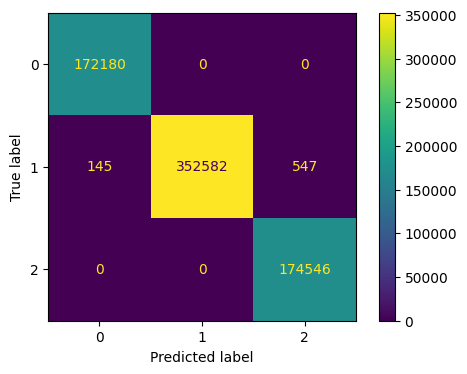

In [198]:
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [199]:
# r2Train = []
# r2Test = []
# for i in range(1, 31):
#     xgb = XGBClassifier(n_estimators=25, max_depth=1)
#     xgb.fit(X_train, y_train)
#     y_train_pred = dt.predict(X_train)
#     r2Train.append(r2_score(y_train, y_train_pred))
#     y_test_pred = dt.predict(X_test)
#     r2Test.append(r2_score(y_test, y_test_pred))

## Tensor Flow Neuro Network

In [200]:
# Write Tensor Flow Neuro Network Code Here

In [201]:
print("hello")

hello
